In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf
from ipywidgets import interact, FloatSlider, Dropdown
import seaborn as sb

# Step 1: Load and Preprocess Data
# Load the data
df = pd.read_csv("BMR_Dataset.csv")

# Display first few rows and check for missing values
print(df.head())

ModuleNotFoundError: No module named 'pandas'

In [2]:
print(df.isna().sum())


user_id     0
age        11
weight      7
height      8
gender     10
BMR         0
dtype: int64


In [3]:
# Fill missing values
df['age'].fillna(df['age'].mean(), inplace=True)
df['weight'].fillna(df['weight'].mean(), inplace=True)
df['height'].fillna(df['height'].mean(), inplace=True)
df['gender'].fillna(df['gender'].mode()[0], inplace=True)

print(df.isna().sum())


user_id    0
age        0
weight     0
height     0
gender     0
BMR        0
dtype: int64


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6616\4071247636.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(df['age'].mean(), inplace=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6616\4071247636.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

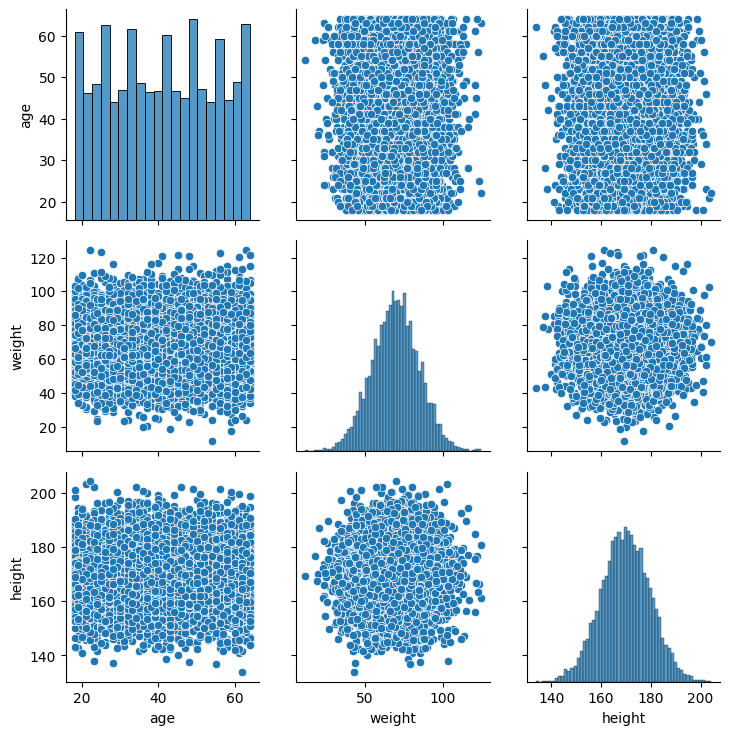

In [4]:
graph = sb.PairGrid(df[["age", "weight", "height"]])
graph.map_diag(sb.histplot)
graph.map_offdiag(sb.scatterplot)

In [5]:
# Encode 'gender' column using OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
encoded_gender = one_hot_encoder.fit_transform(df[['gender']])
encoded_gender_columns = one_hot_encoder.get_feature_names_out(['gender'])
encoded_gender_df = pd.DataFrame(encoded_gender, columns=encoded_gender_columns)

# Concatenate encoded gender with original DataFrame and drop original 'gender' column
df = pd.concat([df.drop(['gender'], axis=1), encoded_gender_df], axis=1)

print(df.head())

   user_id   age     weight      height          BMR  gender_Female  \
0     1243  27.0  73.066833  162.723887  1576.878448            0.0   
1     4971  28.0  77.730284  179.495414  1536.656455            1.0   
2     1629  57.0  85.704790  158.403052  1697.694955            0.0   
3     6201  47.0  67.012186  168.113746  1471.524942            0.0   
4     7833  36.0  79.929512  175.561126  1743.147435            0.0   

   gender_Male  
0          1.0  
1          0.0  
2          1.0  
3          1.0  
4          1.0  


In [10]:
# Define activity factors for calorie calculations
activity_factors = {
    "sedentary": 1.2,
    "lightly_active": 1.375,
    "moderately_active": 1.55,
    "very_active": 1.725,
    "extra_active": 1.9
}

# Step 2: Add calorie requirement columns based on activity levels
for activity, factor in activity_factors.items():
    df[f'calories_{activity}'] = df['BMR'] * factor

# Normalize numerical features
scaler = StandardScaler()
numeric_columns = ['age', 'weight', 'height']
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Step 3: Prepare data for model training
X = df[['age', 'weight', 'height', 'gender_Female', 'gender_Male']].values  # Features for training
y = df['BMR'].values  # Target variable (BMR)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Define and Compile the Model
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('mae') < 42):
            self.model.stop_training = True

stop = myCallback()

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')  # Linear activation for regression
])

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    callbacks=[stop])

model.save('BMR_predictor.h5')
print('model saved')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 64)                  │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,073 (74.50 KB)

 Trainable params: 19,073 (74.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1578369.5000 - mae: 1124.2823 - val_loss: 21957.7363 - val_mae: 118.2294
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 18048.2168 - mae: 105.3608 - val_loss: 8114.1812 - val_mae: 70.3418
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6926.3154 - mae: 64.6972 - val_loss: 4438.2573 - val_mae: 52.3777
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4195.7632 - mae: 50.8675 - val_loss: 3338.3269 - val_mae: 45.5905
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3204.4590 - mae: 45.0225 - val_loss: 3012.5168 - val_mae: 43.5345
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2941.2988 - mae: 43.1395 - val_loss: 2852.8149 - val_mae: 42.6764
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2792.4136 - mae: 42.0359 - val_loss: 2781.2839 - val_mae: 42.2566
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2787.4453 - mae: 42.1628 - val_loss: 2872

model saved


In [8]:
# Step 5: Define the Prediction and Calorie Calculation Function
def predict_bmr_and_calories(age, weight, height, gender, activity_level):
    # Preprocess user input
    gender_male = 1 if gender == 'male' else 0
    gender_female = 1 if gender == 'female' else 0

    # Normalize the input values
    normalized_values = scaler.transform([[age, weight, height]])
    age_norm, weight_norm, height_norm = normalized_values[0]

    # Prepare the input data for prediction
    input_data = np.array([[age_norm, weight_norm, height_norm, gender_female, gender_male]])

    # Predict BMR using the model
    predicted_bmr = model.predict(input_data, verbose=0).item()

    # Calculate daily calorie needs based on activity level
    calories_needed = predicted_bmr * activity_factors[activity_level]

    # Display the results
    print(f"Predicted BMR: {predicted_bmr:.2f}")
    print(f"Estimated Calories Needed (Activity Level - {activity_level}): {calories_needed:.2f}")


In [9]:
# Step 6: Create Interactive Widgets
# Use interactive widgets to get user input for BMR prediction and calorie calculation
interact(
    predict_bmr_and_calories,
    age=FloatSlider(min=7, max=100, step=1, value=30, description="Age:"),
    weight=FloatSlider(min=20, max=200, step=0.5, value=70, description="Weight (kg):"),
    height=FloatSlider(min=90, max=250, step=1, value=170, description="Height (cm):"),
    gender=Dropdown(options=['male', 'female'], value='male', description="Gender:"),
    activity_level=Dropdown(
        options=['sedentary', 'lightly_active', 'moderately_active', 'very_active', 'extra_active'],
        value='lightly_active', description="Activity Level:"
    )
)

interactive(children=(FloatSlider(value=30.0, description='Age:', min=7.0, step=1.0), FloatSlider(value=70.0, …

<function __main__.predict_bmr_and_calories(age, weight, height, gender, activity_level)>

In [23]:
def predict_bmr_and_calories(age, weight, height, gender, activity_level):
    # Placeholder for your function's code
    pass
print(predict_bmr_and_calories)


<function predict_bmr_and_calories at 0x000002563C49D940>


In [24]:
dfc= pd.read_csv("calories.csv")

# Display first few rows and check for missing values
print(dfc.head())

  FoodCategory             FoodItem per100grams Cals_per100grams  \
0  CannedFruit           Applesauce        100g           62 cal   
1  CannedFruit      Canned Apricots        100g           48 cal   
2  CannedFruit  Canned Blackberries        100g           92 cal   
3  CannedFruit   Canned Blueberries        100g           88 cal   
4  CannedFruit      Canned Cherries        100g           54 cal   

  KJ_per100grams  
0         260 kJ  
1         202 kJ  
2         386 kJ  
3         370 kJ  
4         227 kJ  


In [25]:
print(dfc.isna().sum())

FoodCategory        0
FoodItem            0
per100grams         0
Cals_per100grams    0
KJ_per100grams      0
dtype: int64


In [26]:
print("Duplikasi: ", dfc.duplicated().sum())

Duplikasi:  1


In [27]:
# Menghapus duplikat
dfc = dfc.drop_duplicates()

# Mengecek ulang jumlah duplikat
print("Duplikasi setelah penghapusan: ", dfc.duplicated().sum())


Duplikasi setelah penghapusan:  0


In [28]:
# Import library yang diperlukan
import pandas as pd

# Contoh dataset makanan (pastikan Anda sudah memuat dataset ini sebelumnya)
dfc = pd.read_csv("calories.csv")

# Fungsi untuk normalisasi nama makanan
def normalize_food_name(food_name):
    # Mengonversi huruf pertama dari setiap kata menjadi kapital
    return ' '.join([word.capitalize() for word in food_name.split()])

# Fungsi utama untuk menghitung porsi makanan berdasarkan input user
def calculate_food_portion(food_list, total_calories_needed):
    # Validasi jumlah jenis makanan
    if len(food_list) > 10:
        return "Error, maksimal 10 jenis makanan"

    # Normalisasi nama makanan sesuai dengan format di dataset
    normalized_food_list = [normalize_food_name(food) for food in food_list]

    # Filter dataset berdasarkan makanan yang diinput user
    selected_foods = dfc[dfc['FoodItem'].isin(normalized_food_list)]

    # Jika ada makanan yang tidak ditemukan di dataset, tampilkan pesan error
    if selected_foods.empty or len(selected_foods) < len(normalized_food_list):
        return "Beberapa makanan yang diinput tidak ditemukan di dataset."

    # Konversi kolom 'Cals_per100grams' ke tipe numerik (menghapus satuan " cal")
    selected_foods['Cals_per100grams'] = selected_foods['Cals_per100grams'].str.replace(' cal', '').astype(float)

    # Membagi kalori secara merata ke setiap jenis makanan yang dipilih
    calories_per_food = total_calories_needed / len(normalized_food_list)

    # Kalkulasi porsi makanan berdasarkan kalori per 100 gram
    portions = {}
    for index, row in selected_foods.iterrows():
        food_name = row['FoodItem']
        calories_per_100g = row['Cals_per100grams']
        
        # Menghitung gram yang dibutuhkan berdasarkan kalori yang diinginkan
        grams_needed = (calories_per_food / calories_per_100g) * 100
        portions[food_name] = round(grams_needed, 2)  # Membulatkan hingga 2 desimal

    return portions

# Contoh penggunaan fungsi
user_food_list = ["watermelon", "apple", "dragon fruit", "casaba melon"]  # Contoh input user
total_calories_needed = 2000  # Contoh kebutuhan kalori dari hasil prediksi

# Memanggil fungsi dan menampilkan hasil
result = calculate_food_portion(user_food_list, total_calories_needed)
print(result)



{'Apple': 961.54, 'Watermelon': 1666.67, 'Casaba Melon': 1785.71, 'Dragon Fruit': 833.33}


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16868\2416008661.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_foods['Cals_per100grams'] = selected_foods['Cals_per100grams'].str.replace(' cal', '').astype(float)


In [29]:
print(normalize_food_name(user_food_list))

AttributeError: 'list' object has no attribute 'split'